In [ ]:
# Team 7
# Vicent Rosselló, Arnau González, Álvaro Romo

# Imports Necesarios

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor


In [ ]:
dropoffs = pd.read_csv('dropoffs_df.csv')

In [ ]:
# Pre-Procesamiento de datos

hours = [] 
dropoffs['delivery_timestamp'] = pd.to_datetime(dropoffs['delivery_timestamp'])
hours = dropoffs['delivery_timestamp'].dt.hour

long_ = len(hours)
rangos_de_horas =[]
#agrupamos cada 4 horas: de 8 a 12 (1), de 12 a 16 (2) y de 16 a 20 (3)

for i in range(0, long_):
    if hours[i] <= 12:
        rangos_de_horas.append('morning')
    elif 12 < hours[i] < 16:
        rangos_de_horas.append('afternoon')
    elif 16 <= hours[i]:
        rangos_de_horas.append('night')

dropoffs['time_of_day'] = rangos_de_horas

cat_columns = ['truck_size','business_category','floor','partnership_level','time_of_day','driver_id']

# DataFrame with dummies
dum_df = pd.get_dummies(dropoffs[cat_columns], drop_first = False)
dum_df['is_fresh_client_dum'] = [1 if x == True else 0 for x in list(dropoffs['is_fresh_client'])]
df = pd.concat([dropoffs,dum_df], axis = 1) # DataFrame original + dummies

In [ ]:
# Revisar que esté limpio

dropoffs.isna().any()

client_name                  False
truck_size                   False
truck_origin_warehouse       False
delivery_timestamp           False
total_weight                 False
brand_1_coffee_proportion    False
driver_id                    False
is_fresh_client              False
postcode                     False
business_category            False
floor                        False
partnership_level            False
box_count                    False
brand_2_coffee_proportion    False
brand_3_coffee_proportion    False
final_time                   False
time_of_day                  False
dtype: bool

Mean = 413.28
Variance = 215.05


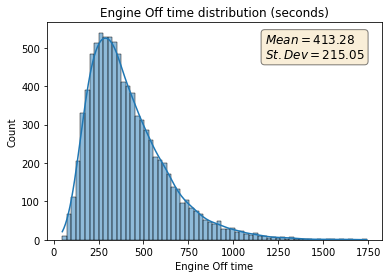

In [ ]:
# Análisis Exploratorio de Datos (EDA)

# Histogram
fig, ax = plt.subplots()
sns.histplot(x = 'final_time', data = df, kde = True)
plt.title('Engine Off time distribution (seconds)')
plt.xlabel('Engine Off time')

mean = np.round(np.mean(df['final_time']),2)
var = np.round(np.std(df['final_time']),2)
print('Mean =', mean)
print('Variance =', var)

textstr = '\n'.join((
    r'$Mean=%.2f$' % (mean, ),
    r'$St. Dev=%.2f$' % (var, )))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.65, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.show()

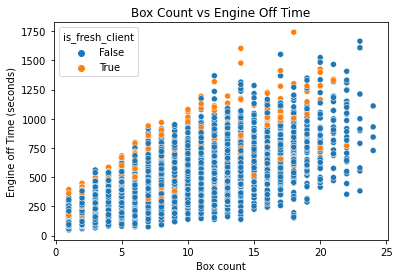

In [ ]:
# Scatter plot of box count and fresh clients

sns.scatterplot(x = 'box_count', y = 'final_time', data = df, color = 'green', hue = 'is_fresh_client')
plt.title('Box Count vs Engine Off Time')
plt.xlabel('Box count')
plt.ylabel('Engine off Time (seconds)')
plt.show()

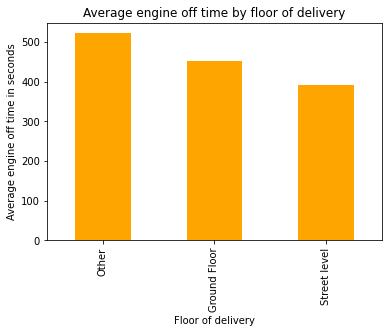

In [ ]:
# Average Final time by floor

aux3 = df.groupby(by = 'floor')['final_time'].mean().sort_values(ascending = False)
aux3.plot.bar(color = 'orange')
plt.title('Average engine off time by floor of delivery')
plt.xlabel('Floor of delivery')
plt.ylabel('Average engine off time in seconds')
plt.show()

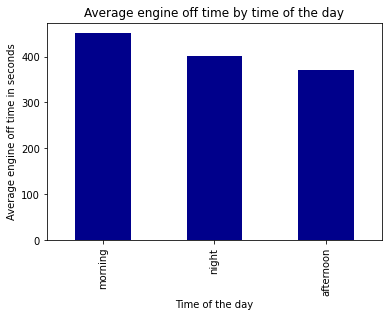

In [ ]:
# Average final day by time of day

aux4 = df.groupby(by = 'time_of_day')['final_time'].mean().sort_values(ascending = False)
aux4.plot.bar(color = 'darkblue')
plt.title('Average engine off time by time of the day')
plt.xlabel('Time of the day')
plt.ylabel('Average engine off time in seconds')
plt.show()

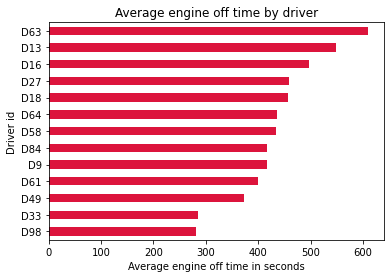

In [ ]:
# Average final time by driver id

aux5 = df.groupby(by = 'driver_id')['final_time'].mean().sort_values(ascending = True)
aux5.plot.barh(color = 'crimson')
plt.title('Average engine off time by driver')
plt.xlabel('Average engine off time in seconds')
plt.ylabel('Driver id')
plt.show()

**Model for Prediction**

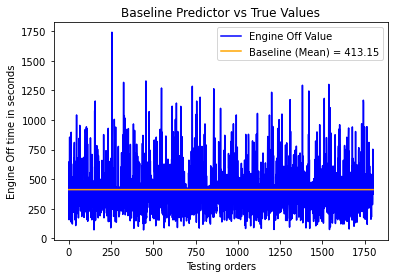

412.0989024308686


In [ ]:
# Baseline Model 

# 1. Baseline Model
y_value = np.array(df['final_time']) # Target to predict

feat1 = np.array(df[['box_count','is_fresh_client_dum']]) # 2 variables

# Train Test Split
train_X, test_X, train_Y, test_Y = train_test_split(feat1, y_value, test_size = 0.2)

baseline_predict = np.mean(train_Y)
aux_bl = np.full((len(test_Y),1),baseline_predict)
bl_mape = mean_absolute_percentage_error(test_Y, aux_bl)

x_aux = np.arange(1,len(test_Y)+1,1)

fig,ax = plt.subplots()
plt.plot(x_aux, test_Y, color = 'blue', label = 'Engine Off Value')
plt.plot(x_aux, aux_bl, color = 'orange', label = 'Baseline (Mean) = 413.15')
plt.legend(loc = 'upper right')
plt.title('Baseline Predictor vs True Values')
plt.xlabel('Testing orders')
plt.ylabel('Engine Off time in seconds')

plt.show()
print(baseline_predict)






In [ ]:
# 2. Stacking Regressor

y_value = np.array(df['final_time']) # Target to predict
log_Y = np.log(y_value)

all_feat = ['box_count','truck_size_Combi','truck_size_Truck','truck_size_Van','business_category_Cafe/Restaurant',
            'business_category_Coffee Retailers','business_category_Hotels','floor_Ground Floor',
            'floor_Other','floor_Street level','partnership_level_Diamond','partnership_level_Key Account',
            'partnership_level_Regular','time_of_day_afternoon',
       'time_of_day_morning', 'time_of_day_night', 'driver_id_D13',
       'driver_id_D16', 'driver_id_D18', 'driver_id_D27', 'driver_id_D33',
       'driver_id_D49', 'driver_id_D58', 'driver_id_D61', 'driver_id_D63',
       'driver_id_D64', 'driver_id_D84', 'driver_id_D9', 'driver_id_D98',
       'is_fresh_client_dum']


features_X = np.array(df[all_feat])

estimators = [('lr', LinearRegression()), ('rf', RandomForestRegressor(n_estimators = 1000, random_state = 42))]
stack_regressor = StackingRegressor(estimators = estimators, final_estimator = RidgeCV())

# Train Test Split
train_X, test_X, train_Y, test_Y = train_test_split(features_X, log_Y, test_size = 0.2)

stack_regressor.fit(train_X, train_Y)
stack_predict = stack_regressor.predict(test_X)
y_hat = np.exp(stack_predict)
real_mape_stack = mean_absolute_percentage_error(np.exp(test_Y), y_hat)
print('Stacking Regressor MAPE =', real_mape_stack)






Stacking Regressor MAPE = 0.16245529861621005


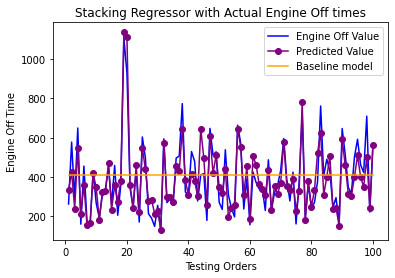

In [ ]:
# Stacking Regressor Plot

fig, ax = plt.subplots()
x_plot = np.arange(1, 101,1)
# Baseline model
bl_model = np.full((100,1), np.mean(np.exp(train_Y)))
plt.plot(x_plot, np.exp(test_Y[0:100]), color = 'blue', label = 'Engine Off Value')
plt.plot(x_plot, y_hat[0:100], color = 'purple', marker = 'o', label = 'Predicted Value')
plt.plot(x_plot, bl_model, color = 'orange', label = 'Baseline model')
plt.legend()
plt.title('Stacking Regressor with Actual Engine Off times')
plt.xlabel('Testing Orders')
plt.ylabel('Engine Off Time')
plt.show()

In [ ]:
# Cross Validation for Stacking Regressor

from sklearn.model_selection import KFold

y_value = np.array(df['final_time']) # Target to predict
log_Y = np.log(y_value)

all_feat = ['box_count','truck_size_Combi','truck_size_Truck','truck_size_Van','business_category_Cafe/Restaurant',
            'business_category_Coffee Retailers','business_category_Hotels','floor_Ground Floor',
            'floor_Other','floor_Street level','partnership_level_Diamond','partnership_level_Key Account',
            'partnership_level_Regular','time_of_day_afternoon',
       'time_of_day_morning', 'time_of_day_night', 'driver_id_D13',
       'driver_id_D16', 'driver_id_D18', 'driver_id_D27', 'driver_id_D33',
       'driver_id_D49', 'driver_id_D58', 'driver_id_D61', 'driver_id_D63',
       'driver_id_D64', 'driver_id_D84', 'driver_id_D9', 'driver_id_D98',
       'is_fresh_client_dum']


features = np.array(df[all_feat])



skf = KFold(n_splits = 10)
skf.get_n_splits(features, log_Y)
mapes_list = []
estimators = [('lr', LinearRegression()), ('rf', RandomForestRegressor(n_estimators = 1000, random_state = 42))]
i = 1

for train_index, test_index in skf.split(features, log_Y):
  print('i =',i)
  train_X, test_X = features[train_index], features[test_index]
  train_Y, test_Y = log_Y[train_index], log_Y[test_index]
  stack_regressor = StackingRegressor(estimators = estimators, final_estimator = RidgeCV())
  stack_regressor.fit(train_X, train_Y)
  stack_predict = stack_regressor.predict(test_X)
  y_hat = np.exp(stack_predict)
  mape = mean_absolute_percentage_error(np.exp(test_Y), y_hat)
  mapes_list.append(mape)
  i = i+1


print('MAPE CV =',np.mean(mapes_list))

  




i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
MAPE CV = 0.17984778591022954


In [ ]:
# Linear Regression for coefficient interpretation 

y_value = np.array(df['final_time']) # Target to predict
log_Y = np.log(y_value)

all_feat = ['box_count','truck_size_Combi','truck_size_Truck','truck_size_Van','business_category_Cafe/Restaurant',
            'business_category_Coffee Retailers','business_category_Hotels','floor_Ground Floor',
            'floor_Other','floor_Street level','partnership_level_Diamond','partnership_level_Key Account',
            'partnership_level_Regular','time_of_day_afternoon',
       'time_of_day_morning', 'time_of_day_night', 'driver_id_D13',
       'driver_id_D16', 'driver_id_D18', 'driver_id_D27', 'driver_id_D33',
       'driver_id_D49', 'driver_id_D58', 'driver_id_D61', 'driver_id_D63',
       'driver_id_D64', 'driver_id_D84', 'driver_id_D9', 'driver_id_D98',
       'is_fresh_client_dum']


features_X = np.array(df[all_feat])

# Train Test Split
train_X, test_X, train_Y, test_Y = train_test_split(features_X, log_Y, test_size = 0.2)

lr_int = LinearRegression()
lr_int.fit(train_X, train_Y)
lr_predict = lr_int.predict(test_X)
mape_lr = mean_absolute_percentage_error(np.exp(test_Y), np.exp(lr_predict))
print('MAPE LR =',mape_lr)

coefs = lr_int.coef_
print(len(all_feat))





MAPE LR = 0.17058294234500487
30


In [ ]:
coefs_df = pd.DataFrame({'Variable':all_feat, 'Coefficient':coefs, 'Absolute coefficient':np.abs(coefs)})
coefs_df.sort_values(by = 'Absolute coefficient', ascending = False)

,Variable,Coefficient,Absolute coefficient
28,driver_id_D98,-0.433344,0.433344
20,driver_id_D33,-0.410313,0.410313
24,driver_id_D63,0.367127,0.367127
29,is_fresh_client_dum,0.317124,0.317124
16,driver_id_D13,0.275037,0.275037
17,driver_id_D16,0.204067,0.204067
9,floor_Street level,-0.170230,0.170230
8,floor_Other,0.165456,0.165456
14,time_of_day_morning,0.118006,0.118006
21,driver_id_D49,-0.108798,0.108798


In [ ]:
# Cross Validation for Linear Regression

from sklearn.model_selection import KFold

y_value = np.array(df['final_time']) # Target to predict
log_Y = np.log(y_value)

all_feat = ['box_count','truck_size_Combi','truck_size_Truck','truck_size_Van','business_category_Cafe/Restaurant',
            'business_category_Coffee Retailers','business_category_Hotels','floor_Ground Floor',
            'floor_Other','floor_Street level','partnership_level_Diamond','partnership_level_Key Account',
            'partnership_level_Regular','time_of_day_afternoon',
       'time_of_day_morning', 'time_of_day_night', 'driver_id_D13',
       'driver_id_D16', 'driver_id_D18', 'driver_id_D27', 'driver_id_D33',
       'driver_id_D49', 'driver_id_D58', 'driver_id_D61', 'driver_id_D63',
       'driver_id_D64', 'driver_id_D84', 'driver_id_D9', 'driver_id_D98',
       'is_fresh_client_dum']


features = np.array(df[all_feat])



skf = KFold(n_splits = 10)
skf.get_n_splits(features, log_Y)
mapes_list = []
i = 1

for train_index, test_index in skf.split(features, log_Y):
  print('i =',i)
  train_X, test_X = features[train_index], features[test_index]
  train_Y, test_Y = log_Y[train_index], log_Y[test_index]

  lr = LinearRegression()
  lr.fit(train_X, train_Y)
  lr_predict = lr.predict(test_X)
  y_hat = np.exp(lr_predict)
  mape = mean_absolute_percentage_error(np.exp(test_Y), y_hat)
  mapes_list.append(mape)
  i = i+1


print('MAPE CV =',np.mean(mapes_list))

  




i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
MAPE CV = 0.1863555565055386
